## Feature Extraction

# Imports

In [1]:
import sklearn
import numpy as np
import os

import glob
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.dates as md
import scipy
import tensorflow.keras.utils
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from sklearn import preprocessing
import os.path
import mne
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
import pickle




# Test on one subject first and add proper labels.

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


# Define Helper Functions

In [2]:
def bin_power(X, Band, Fs):
    C = np.fft.fft(X)
    C = abs(C)
    Power = np.zeros(len(Band) - 1)
    for Freq_Index in range(0, len(Band) - 1):
        Freq = float(Band[Freq_Index])
        Next_Freq = float(Band[Freq_Index + 1])
        Power[Freq_Index] = sum(
            C[int(np.floor(Freq / Fs * len(X))):
                int(np.floor(Next_Freq / Fs * len(X)))]
        )
    Power_Ratio = Power / sum(Power)
    return Power, Power_Ratio

# Print Confusion Matrix and accuracy for given data.
def print_stats(y_test, pred):
    CM = confusion_matrix(y_test,pred)
    # TN, FP, FN, TP = confusion_matrix(y_test, pred).ravel()

    Accuracy = accuracy_score(y_test,pred)
    # Precision = TP / (TP + FP)
    # Recall = TP / (TP + FN)
    # F1 = 2 * (Precision * Recall) / (Precision + Recall)

    print('==='*20)
    print('Accuracy = '+str(Accuracy))
    # print('==='*20)
    # print('Precision = '+str(Precision))
    # print('==='*20)
    # print('Recall = '+str(Recall))
    # print('==='*20)
    # print('F1 = '+str(F1))
    # print('==='*20)

    return CM

# ML Pipeline for SKlearn Classifiers
def ML_Pipeline(clf_name):
    clf = Classifiers[clf_name]
    fit = clf.fit(X_train, y_train)
    pred = clf.predict(X_test)

    pkl_filename = old_path + "/Saved_Models/" + clf_name + "_model.pkl"
    with open(pkl_filename, 'wb') as file:
        pickle.dump(clf, file)

    np.asarray(pred)

    SK_Model = print_stats(y_test, pred)

    return SK_Model, pred

# sliding window and format cnn data functions were pulled from labs
def sliding_window(df, window_size, stride, fs = 1000):
    # This function only works for continous dfs (not multiple combined participant dfs)
    dfs = []
    df_cop = df.copy() # create copy of dataframe
    starting_index = df_cop.index[0]
    ending_index = int(df_cop.index[0] + fs*window_size)
    while ending_index <= df_cop.index[-1]:
        windowed_df = df_cop.loc[(df_cop.index >= starting_index) & (df_cop.index <= ending_index)] 
        dfs.append(windowed_df)
        starting_index = int(starting_index + fs*stride)
        ending_index = int(ending_index + fs*stride)
    return dfs

def format_cnn_data(windows, x_channels = ['TP9', 'AF7', 'AF8', 'TP10'], y_channel='Label'):
    # This function takes in a list of window dfs and formats the data into a shape keras expects
    # Shape: (n_samples, n_window_samples, n_features, 1)
    data_x = []
    data_y = []
    for window in windows:
        window_x = window[x_channels].values
        window_x = window_x.reshape(-1, window_x.shape[0], window_x.shape[1], 1)
        window_y =  max(window[y_channel].values)
        if len(data_x) == 0:
            data_x = window_x
            data_y = window_y
        else:
            data_x = np.vstack((data_x, window_x))
            data_y = np.vstack((data_y, window_y))
    # We need to categorize our class labels
    data_y = to_categorical(data_y)
    return data_x, data_y

# extract_bands takes in a dataframe and extracts features for the delta, theta, alpha, and beta powers.
# theta seems to be 0 across the board so i excluded it from the extracted set
# this function goes through every sensor
def extract_bands(df):

    TP9_data = df.TP9
    TP10_data = df.TP10
    AF7_data = df.AF7
    AF8_data = df.AF8
    # Sampling frequency usually is 512 but this dataset seems to have been downsampled to 200Hz because of the sensors used (Muse Headband)
    Fs = 200

    delta_list = []
    theta_list = []
    alpha_list = []
    beta_list = []
    label_list = []
    Bands_test = [0.5,3,7,14,30]

    # Change this as needed?
    increment = 50

    for x in range(0, (df.shape[0] - increment), increment):
        power, power_ratio = bin_power(TP9_data[x:x+increment], Bands_test, Fs)
        delta_list.append(power[0])
        theta_list.append(power[1])
        alpha_list.append(power[2])
        beta_list.append(power[3])
        # LABEL GOES HERE PLEASE EDIT
        label_list.append(df.loc[x, 'Label'])

    temp_frame = {'TP9_Theta': theta_list,
                'TP9_Alpha': alpha_list,
                'TP9_Beta': beta_list,
    }

    df1 = pd.DataFrame(temp_frame, columns=['TP9_Theta', 'TP9_Alpha', 'TP9_Beta'])

    # ----------------------------------------------------
    delta_list.clear()
    theta_list.clear()
    alpha_list.clear()
    beta_list.clear()

    for x in range(0, (df.shape[0] - increment), increment):
        power, power_ratio = bin_power(TP10_data[x:x+increment], Bands_test, Fs)
        delta_list.append(power[0])
        theta_list.append(power[1])
        alpha_list.append(power[2])
        beta_list.append(power[3])

    temp_frame = {'TP10_Theta': theta_list,
                'TP10_Alpha': alpha_list,
                'TP10_Beta': beta_list,
    }

    df2 = pd.DataFrame(temp_frame, columns=['TP10_Theta', 'TP10_Alpha', 'TP10_Beta'])

    # ----------------------------------------------------
    delta_list.clear()
    theta_list.clear()
    alpha_list.clear()
    beta_list.clear()

    for x in range(0, (df.shape[0] - increment), increment):
        power, power_ratio = bin_power(AF7_data[x:x+increment], Bands_test, Fs)
        delta_list.append(power[0])
        theta_list.append(power[1])
        alpha_list.append(power[2])
        beta_list.append(power[3])

    temp_frame = {'AF7_Theta': theta_list,
                'AF7_Alpha': alpha_list,
                'AF7_Beta': beta_list,
    }

    df3 = pd.DataFrame(temp_frame, columns=['AF7_Theta', 'AF7_Alpha', 'AF7_Beta'])

    # ----------------------------------------------------
    delta_list.clear()
    theta_list.clear()
    alpha_list.clear()
    beta_list.clear()

    for x in range(0, (df.shape[0] - increment), increment):
        power, power_ratio = bin_power(AF8_data[x:x+increment], Bands_test, Fs)
        delta_list.append(power[0])
        theta_list.append(power[1])
        alpha_list.append(power[2])
        beta_list.append(power[3])

    temp_frame = {'AF8_Theta': theta_list,
                'AF8_Alpha': alpha_list,
                'AF8_Beta': beta_list,
                'Label':label_list
    }

    df4 = pd.DataFrame(temp_frame, columns=['AF8_Theta', 'AF8_Alpha', 'AF8_Beta', 'Label'])

    result = pd.concat([df1, df2, df3, df4], axis=1)
    return result

In [56]:
# This line was used for debugging
# old_path = ("/home/nikhil/Documents/Pycharm Projects/BioRoboticsSingle")

# Label based CSV files and remove Right Aux Column

In [3]:
path = os.getcwd()

if str(path).find("Labeled") != -1:
    print("Data should already exist")
else:
    old_path = path
    os.chdir(path)
    extension = 'csv'
    #combine all files in the list
    all_filenames = [i for i in glob.glob('*.{}'.format(extension))]

    # Parse through csv files and remove noise column as well as add labels
    for f in all_filenames:
        data = pd.read_csv(f)
        data.drop('Right AUX', inplace=True, axis=1)
        name = f + "_modified.csv"

        if "relaxed" in f:
            data["Label"] = int(0) # Relaxed
        if "neutral" in f:
            data["Label"] = int(1) # Neutral
        if "concentrating" in f:
            data["Label"] = int(2) # Concentrating

        data.to_csv(path + '/Labeled_Data/' + name)

    # Switch to labeled data directory
    os.chdir(path + "/Labeled_Data")

In [4]:
display(os.getcwd())

# This cell creates a massive dataframe of all the subjects data separated into the mental states

# RELAXED DATAFRAME
temp1 = pd.read_csv('subjecta-relaxed-1.csv_modified.csv')
temp2 = pd.read_csv('subjecta-relaxed-2.csv_modified.csv')
temp3 = pd.read_csv('subjectb-relaxed-1.csv_modified.csv')
temp4 = pd.read_csv('subjectb-relaxed-2.csv_modified.csv')
temp5 = pd.read_csv('subjectc-relaxed-1.csv_modified.csv')
temp6 = pd.read_csv('subjectc-relaxed-2.csv_modified.csv')
temp7 = pd.read_csv('subjectd-relaxed-1.csv_modified.csv')
temp8 = pd.read_csv('subjectd-relaxed-2.csv_modified.csv')


relaxed_df = pd.concat([temp1, temp2, temp3, temp4, temp5, temp6, temp7,temp8], ignore_index=True)

# NEUTRAL DATAFRAME
temp1 = pd.read_csv('subjecta-neutral-1.csv_modified.csv')
temp2 = pd.read_csv('subjecta-neutral-2.csv_modified.csv')
temp3 = pd.read_csv('subjectb-neutral-1.csv_modified.csv')
temp4 = pd.read_csv('subjectb-neutral-2.csv_modified.csv')
temp5 = pd.read_csv('subjectc-neutral-1.csv_modified.csv')
temp6 = pd.read_csv('subjectc-neutral-2.csv_modified.csv')
temp7 = pd.read_csv('subjectd-neutral-1.csv_modified.csv')
temp8 = pd.read_csv('subjectd-neutral-2.csv_modified.csv')

neutral_df = pd.concat([temp1, temp2, temp3, temp4, temp5, temp6, temp7,temp8], ignore_index=True)


# CONCENTRATING DATAFRAME
temp1 = pd.read_csv('subjecta-concentrating-1.csv_modified.csv')
temp2 = pd.read_csv('subjecta-concentrating-2.csv_modified.csv')
temp3 = pd.read_csv('subjectb-concentrating-1.csv_modified.csv')
temp4 = pd.read_csv('subjectb-concentrating-2.csv_modified.csv')
temp5 = pd.read_csv('subjectc-concentrating-1.csv_modified.csv')
temp6 = pd.read_csv('subjectc-concentrating-2.csv_modified.csv')
temp7 = pd.read_csv('subjectd-concentrating-1.csv_modified.csv')
temp8 = pd.read_csv('subjectd-concentrating-2.csv_modified.csv')

concentrating_df = pd.concat([temp1, temp2, temp3, temp4, temp5, temp6, temp7,temp8], ignore_index=True)

'/home/nikhil/Documents/Pycharm Projects/BioRoboticsSingle/Labeled_Data'

# Get 80/20 Split of raw features for Deep Learning Models and Real-Time

In [5]:
display(round(relaxed_df.shape[0]*.8))
display(round(neutral_df.shape[0]*.8))
display(round(concentrating_df.shape[0]*.8))

# As the title of this cell says, this part splits each mental state into an 80/20 split. Then, it combines all the
# 80%s into one dataframe, and all the 20%s into another. Finally, we combine them togetether again. This allows
# us to do a test/train split of 0.2 and have all classes be equally represented in both the testing and training sets

split_1 = relaxed_df.iloc[:round(relaxed_df.shape[0]*.8),:]
split_2 = relaxed_df.iloc[round(relaxed_df.shape[0]*.8):,:]
df_80 = pd.concat([split_1], ignore_index=True)
df_20 = pd.concat([split_2], ignore_index=True)
display(df_80.shape)

split_1 = neutral_df.iloc[:round(neutral_df.shape[0]*.8),:]
split_2 = neutral_df.iloc[round(neutral_df.shape[0]*.8):,:]
df_80 = pd.concat([df_80, split_1], ignore_index=True)
df_20 = pd.concat([df_20, split_2], ignore_index=True)
display(df_80.shape)

split_1 = concentrating_df.iloc[:round(concentrating_df.shape[0]*.8),:]
split_2 = concentrating_df.iloc[round(concentrating_df.shape[0]*.8):,:]
df_80 = pd.concat([df_80, split_1], ignore_index=True)
df_20 = pd.concat([df_20, split_2], ignore_index=True)
display(df_80.shape)

raw_set = pd.concat([df_80, df_20], ignore_index=True)
raw_set = raw_set.iloc[:,1:]
df_20 = df_20.iloc[:,1:]
df_20.to_csv(old_path + "/Saved_Data/Raw_Test.csv")

93610

87024

75187

(93610, 7)

(180634, 7)

(255821, 7)

# Get 80/20 Split of extracted features for Non-Deep Learning Models

In [7]:
relaxed_extracted_df= extract_bands(relaxed_df)
neutral_extracted_df= extract_bands(neutral_df)
concentrating_extracted_df= extract_bands(concentrating_df)

display(round(relaxed_extracted_df.shape[0]*.8))
display(round(neutral_extracted_df.shape[0]*.8))
display(round(concentrating_extracted_df.shape[0]*.8))

split_1_extracted = relaxed_extracted_df.iloc[:round(relaxed_extracted_df.shape[0]*.8),:]
split_2_extracted = relaxed_extracted_df.iloc[round(relaxed_extracted_df.shape[0]*.8):,:]
df_80_extracted = pd.concat([split_1_extracted], ignore_index=True)
df_20_extracted = pd.concat([split_2_extracted], ignore_index=True)
display(df_80_extracted.shape)

split_1_extracted = neutral_extracted_df.iloc[:round(neutral_extracted_df.shape[0]*.8),:]
split_2_extracted = neutral_extracted_df.iloc[round(neutral_extracted_df.shape[0]*.8):,:]
df_80_extracted = pd.concat([df_80_extracted, split_1_extracted], ignore_index=True)
df_20_extracted = pd.concat([df_20_extracted, split_2_extracted], ignore_index=True)
display(df_80_extracted.shape)

split_1_extracted = concentrating_extracted_df.iloc[:round(concentrating_extracted_df.shape[0]*.8),:]
split_2_extracted = concentrating_extracted_df.iloc[round(concentrating_extracted_df.shape[0]*.8):,:]
df_80_extracted = pd.concat([df_80_extracted, split_1_extracted], ignore_index=True)
df_20_extracted = pd.concat([df_20_extracted, split_2_extracted], ignore_index=True)
display(df_80_extracted.shape)

extracted_set = pd.concat([df_80_extracted, df_20_extracted], ignore_index=True)
extracted_set.to_csv(r'Extracted_Feature_Frame.csv')

1872

1740

1503

(1872, 13)

(3612, 13)

(5115, 13)

# Define CNN Model

In [8]:
model = models.Sequential()
model.add(layers.Conv2D(32, 3, activation='relu', input_shape=(10001,4,1)))
# model.add(layers.Conv2D(32, 3, activation='sigmoid', padding = 'same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.4))

#model.add(layers.MaxPooling2D((2, 2), padding='same'))

model.add(layers.Conv2D(64, 3, activation='sigmoid', padding = 'same'))
# model.add(layers.Conv2D(64, 3, activation='sigmoid', padding = 'same'))
model.add(layers.MaxPooling2D((2, 2), padding='same'))
model.add(layers.Dropout(0.5))

model.add(layers.Flatten())

model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.8))
model.add(layers.Dense(3, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 9999, 2, 32)       320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 4999, 1, 32)       0         
_________________________________________________________________
dropout (Dropout)            (None, 4999, 1, 32)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 4999, 1, 64)       18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 2500, 1, 64)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2500, 1, 64)       0         
_________________________________________________________________
flatten (Flatten)            (None, 160000)            0

155

(155, 10001, 4, 1)

(155, 3)

Epoch 1/30
4/4 [==============================] - 3s 154ms/step - loss: 372.7216 - accuracy: 0.2312 - val_loss: 244.6147 - val_accuracy: 0.3548
Epoch 2/30
4/4 [==============================] - 0s 20ms/step - loss: 149.2395 - accuracy: 0.2973 - val_loss: 58.5988 - val_accuracy: 0.4194
Epoch 3/30
4/4 [==============================] - 0s 21ms/step - loss: 137.6081 - accuracy: 0.2405 - val_loss: 23.8012 - val_accuracy: 0.5484
Epoch 4/30
4/4 [==============================] - 0s 21ms/step - loss: 44.2660 - accuracy: 0.4265 - val_loss: 12.1864 - val_accuracy: 0.3548
Epoch 5/30
4/4 [==============================] - 0s 20ms/step - loss: 13.2272 - accuracy: 0.5731 - val_loss: 6.0880 - val_accuracy: 0.3871
Epoch 6/30
4/4 [==============================

<AxesSubplot:>

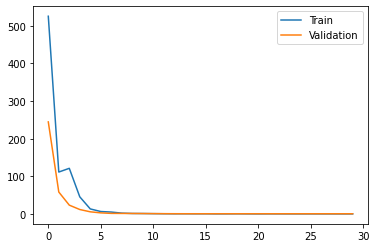

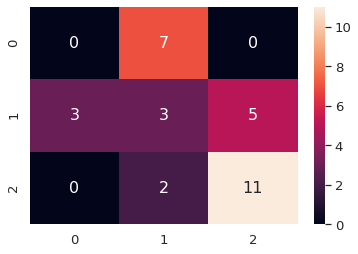

In [9]:
# Create sliding windows from raw dataframe with window size of 10s and stride of 2
windows = sliding_window(raw_set, window_size = 10, stride = 2)
display(len(windows))
x, y = format_cnn_data(windows)
display(x.shape, y.shape)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=False)

# Compile CNN using sliding window data
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=30, shuffle = False)

# Plot train vs. validation loss plot
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.legend(loc="upper right")

# Reshape output so confusion matrix can be printed
y_pred = model.predict(x_test)
pred = np.argmax(y_pred, axis=1)
pred[1]
y_testpred = np.argmax(y_test, axis=1)
y_testpred[1]

# Print confusion matrix and accuracy
CM = print_stats(y_testpred, pred)

# Format plot for confusion matrix
df_cm = pd.DataFrame(CM)
plt.figure(figsize=(6,4))
sn.set(font_scale=1.2)
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16})

# Save CNN Model

In [37]:
model.save(old_path + '/Saved_Models/CNN')

INFO:tensorflow:Assets written to: /home/nikhil/Documents/Pycharm Projects/BioRoboticsSingle/Saved_Models/CNN/assets


# AutoEncoder data Pre-processing

In [16]:
# Create sliding windows from raw dataframe with window size of 10s and stride of 2
windows = sliding_window(raw_set, window_size = 10, stride = 2)
x, y = format_cnn_data(windows)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=False)
x_train.shape
x_test.shape

# Reshape dataset to dimension 2 (Normalizer only works with data of shape 2)
x_train = x_train.reshape(124, 10001*4*1)
x_test = x_test.reshape(31, 10001*4*1)

# Preprocess and normalize data using l2 normalizer
x_train = preprocessing.normalize(x_train, norm='l2')
x_test = preprocessing.normalize(x_test, norm='l2')

# Reshape to dimension 4 to be used for classifiers
x_train = x_train.reshape(124, 10001, 4)
x_test = x_test.reshape(31, 10001, 4)

# Re-index data
x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

x_train.shape
x_test.shape

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 10001, 4, 128)     1280      
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 10001, 4, 64)      73792     
Total params: 75,072
Trainable params: 75,072
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
4/4 [==============================] - 1s 210ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 2/10
4/4 [==============================] - 1s 172ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00

In [33]:
# Define Autoencoder

Epoch 1/50
1/1 [==============================] - 1s 510ms/step - loss: 15.1006 - val_loss: -29.3718
Epoch 2/50
1/1 [==============================] - 0s 29ms/step - loss: -64.0588 - val_loss: -352.8045
Epoch 3/50
1/1 [==============================] - 0s 33ms/step - loss: -626.0219 - val_loss: -1009.3872
Epoch 4/50
1/1 [==============================] - 0s 32ms/step - loss: -1781.5422 - val_loss: -2176.2253
Epoch 5/50
1/1 [==============================] - 0s 29ms/step - loss: -3828.8003 - val_loss: -4066.1448
Epoch 6/50
1/1 [==============================] - 0s 28ms/step - loss: -7088.4604 - val_loss: -6858.3662
Epoch 7/50
1/1 [==============================] - 0s 27ms/step - loss: -11860.0967 - val_loss: -10788.3203
Epoch 8/50
1/1 [

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.regularizers import l1

# Reshape data to dimension 2
x_train = x_train.reshape(124, 10001*4*1)
x_test = x_test.reshape(31, 10001*4*1)

# Define Basic Sparse Autoencoder
input_l=Input(shape=(40004,))

encoding_1=Dense(256, activation='relu', activity_regularizer=l1(0.001))(input_l)
bottleneck=Dense(32, activation='relu', activity_regularizer=l1(0.001))(encoding_1)
decoding_1=Dense(256, activation='relu', activity_regularizer=l1(0.001))(bottleneck)
output_l=Dense(40004, activation='sigmoid')(decoding_1)
autoencoder=Model(inputs=[input_l],outputs=[output_l])
encoder=Model(inputs=[input_l],outputs=[bottleneck])
encoded_input=Input(shape=(32,))
decoded_layer_2=autoencoder.layers[-2](encoded_input)
decoded=autoencoder.layers[-1](decoded_layer_2)
decoder=Model(inputs=[encoded_input],outputs=[decoded])
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=False,
                validation_data=(x_test, x_test))

# Save Sparse Autoencoder model

In [38]:
autoencoder.save(old_path + '/Saved_Models/Autoencoder')

INFO:tensorflow:Assets written to: /home/nikhil/Documents/Pycharm Projects/BioRoboticsSingle/Saved_Models/Autoencoder/assets


Epoch 1/10
4/4 [==============================] - 0s 27ms/step - loss: 0.8225 - accuracy: 0.5484 - val_loss: 0.9289 - val_accuracy: 0.5484
Epoch 2/10
4/4 [==============================] - 0s 22ms/step - loss: 0.8047 - accuracy: 0.5806 - val_loss: 0.9290 - val_accuracy: 0.5484
Epoch 3/10
4/4 [==============================] - 0s 23ms/step - loss: 0.8012 - accuracy: 0.6129 - val_loss: 0.9284 - val_accuracy: 0.5484
Epoch 4/10
4/4 [==============================] - 0s 21ms/step - loss: 0.8035 - accuracy: 0.5887 - val_loss: 0.9282 - val_accuracy: 0.5484
Epoch 5/10
4/4 [==============================] - 0s 21ms/step - loss: 0.8175 - accuracy: 0.5565 - val_loss: 0.9285 - val_accuracy: 0.5484
Epoch 6/10
4/4 [====

<AxesSubplot:>

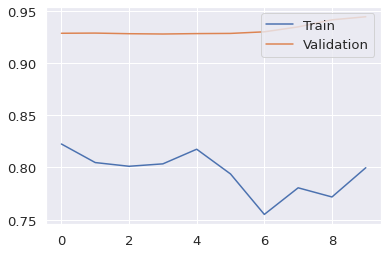

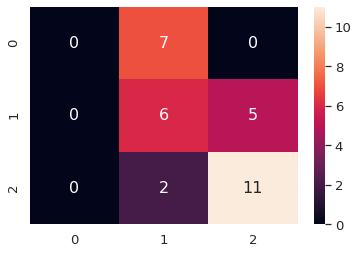

In [34]:
# Create sliding windows from raw dataframe with window size of 10s and stride of 2
windows = sliding_window(raw_set, window_size = 10, stride = 2)
x, y = format_cnn_data(windows)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=False)

# Reshape data to dimension 2 to encode using autoencoder
x_train = x_train.reshape(124, 10001*4*1)
x_test = x_test.reshape(31, 10001*4*1)

# Encode data using the Spare Autoencoder
x_train_encoder = autoencoder.predict(x_train)
x_test_encoder = autoencoder.predict(x_test)

# Reshape data back to dimension 4 to be used by the CNN Classifier
x_train_encoder = x_train.reshape(124, 10001, 4, 1)
x_test_encoder = x_test.reshape(31, 10001, 4, 1)

# Re-train CNN using the encoded data
history = model.fit(x_train_encoder, y_train, epochs=10, shuffle=False, validation_data=(x_test_encoder, y_test))
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.legend(loc="upper right")

# Predict using the encoded data
y_pred = model.predict(x_test_encoder)

# Reshape output so confusion matrix can be printed
pred = np.argmax(y_pred, axis=1)
pred[1]
y_testpred = np.argmax(y_test, axis=1)
y_testpred[1]

# Print confusion matrix and accuracy
CM = print_stats(y_testpred, pred)

# Format plot for confusion matrix
df_cm = pd.DataFrame(CM)
plt.figure(figsize=(6,4))
sn.set(font_scale=1.2)
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16})

# Feature Extraction

Creating RawArray with float64 data, n_channels=4, n_times=319776
    Range : 0 ... 319775 =      0.000 ...   624.561 secs
Ready.


'Alpha PSD for Nontarget'

Effective window size : 4.000 (s)


'Theta PSD for Nontarget'

Effective window size : 4.000 (s)


'Beta PSD for Nontarget'

Effective window size : 4.000 (s)


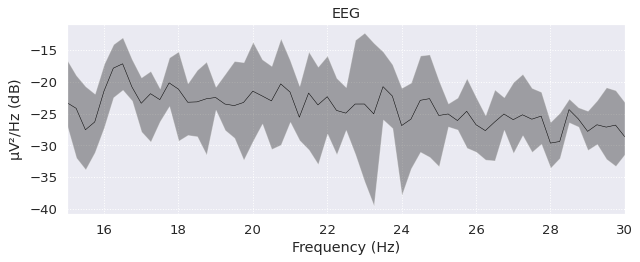

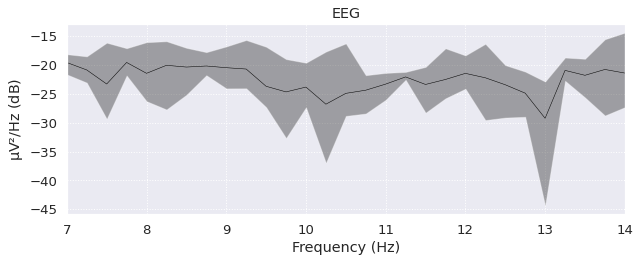

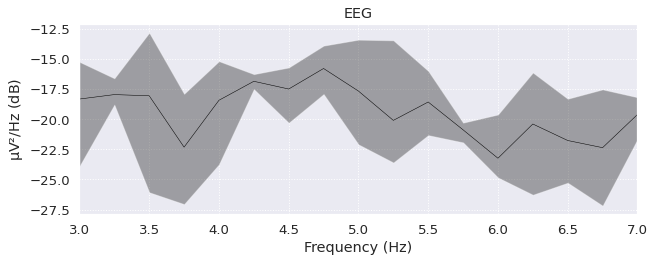

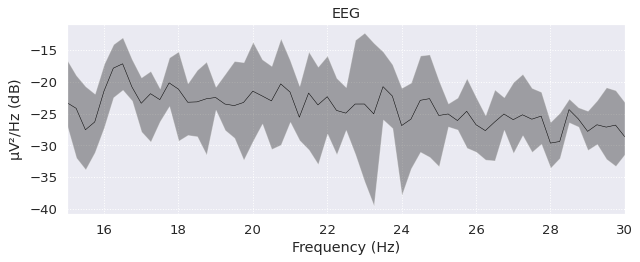

In [13]:
from fooof import FOOOFGroup
from fooof.bands import Bands
from fooof.analysis import get_band_peak_fg
from fooof.plts.spectra import plot_spectrum

# Drop Non-EEG Columns
df_mne = raw_set.drop(columns=['timestamps', 'Label'])
# Rename Channels
ch_names = list(df_mne.columns)

# Create MNE Info to apply to csv data
info = mne.create_info(ch_names, 512, ch_types='eeg')
#info['chs'][-1]['kind']

# Rescale data
df_mne = df_mne.apply(lambda x: x/10000000)

# Create Raw Array
raw = mne.io.RawArray(df_mne.transpose(), info)

bands = Bands({'theta': [3, 7],
               'alpha': [7, 14],
               'beta': [15, 30]})

display("Alpha PSD for Nontarget")
raw.plot_psd(area_mode='range', tmax=10.0, show=False, average=True, fmin=bands.alpha[0], fmax = bands.alpha[1])
display("Theta PSD for Nontarget")
raw.plot_psd(area_mode='range', tmax=10.0, show=False, average=True, fmin=bands.theta[0], fmax = bands.theta[1])
display("Beta PSD for Nontarget")
raw.plot_psd(area_mode='range', tmax=10.0, show=False, average=True, fmin=bands.beta[0], fmax = bands.beta[1])

Accuracy = 0.9788897576231431
Accuracy = 0.9788897576231431


<AxesSubplot:>

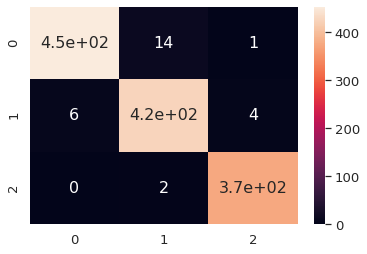

In [31]:
from sklearn.model_selection import train_test_split

# List of classifiers and settings for ML Pipeline
Classifiers = {
    'SVM':svm.SVC(kernel='sigmoid', C=0.1, probability=True),
    'KNN':KNeighborsClassifier(n_neighbors=3, weights='uniform', algorithm='auto', leaf_size=30, p=2, metric='minkowski'),
    'DTC':DecisionTreeClassifier(random_state=10,min_samples_leaf=2,max_features="log2",criterion="entropy"),
    'SGD':SGDClassifier(loss="squared_hinge", penalty="l1", max_iter=2000, shuffle=False),
}

# Create x and y sets from pre-made extracted_features_dataframe
# y is only labels
y = extracted_set.Label
# x contains features (power bands)
x = extracted_set
x.drop(columns=['Label'])
X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=0.2, shuffle=False)

# Use extracted features dataset and pass through Decision Tree Classifier
SK_Model, pred = ML_Pipeline('DTC')

# Print confusion matrix and accuracy
CM = print_stats(y_test, pred)

# Format plot for confusion matrix
df_cm = pd.DataFrame(CM)
plt.figure(figsize=(6,4))
sn.set(font_scale=1.2)
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16})

Accuracy = 0.6223612197028929
Accuracy = 0.6223612197028929


<AxesSubplot:>

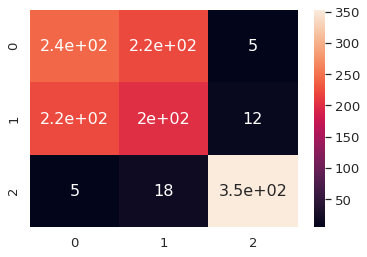

In [16]:
# Use extracted features dataset and pass through K-Nearest Neighbor
SK_Model, pred = ML_Pipeline('KNN')

# Print confusion matrix and accuracy
CM = print_stats(y_test, pred)

# Format plot for confusion matrix
df_cm = pd.DataFrame(CM)
plt.figure(figsize=(6,4))
sn.set(font_scale=1.2)
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16})

Accuracy = 0.4151681000781861
Accuracy = 0.4151681000781861


<AxesSubplot:>

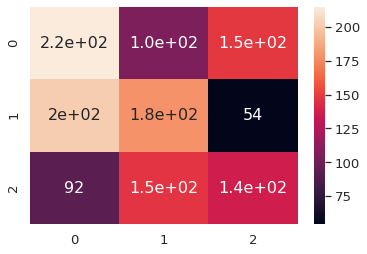

In [17]:
# Use extracted features dataset and pass through Stochastic Gradient Descent
SK_Model, pred = ML_Pipeline('SGD')

# Print confusion matrix and accuracy
CM = print_stats(y_test, pred)

# Format plot for confusion matrix
df_cm = pd.DataFrame(CM)
plt.figure(figsize=(6,4))
sn.set(font_scale=1.2)
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16})

Accuracy = 0.4151681000781861
Accuracy = 0.4151681000781861


<AxesSubplot:>

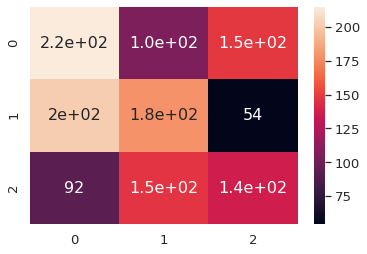

In [32]:
# Use extracted features dataset and pass through Support Vector Machine
SK_Model, pred = ML_Pipeline('SVM')

# Print confusion matrix and accuracy
CM = print_stats(y_test, pred)

# Format plot for confusion matrix
df_cm = pd.DataFrame(CM)
plt.figure(figsize=(6,4))
sn.set(font_scale=1.2)
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16})
